# OD - Second Delivery

### Group 14 - 93294, 93661, 96409
#### Individual Contributions: Madalena Sampaio, 93294

## Heuristic - Nearest Neighbor algorithm with 2-opt

Import libraries

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

Choose and import the dataset

In [59]:
filename = "benchmarks.xlsx"
sheet_name = "54_nodes"        # Choose "54_nodes" or "101_nodes"
capacity = 100                 # 100 for "54_nodes", 112 for "101_nodes" 

df = pd.read_excel(filename, sheet_name=sheet_name)
df.head()

,Location,X,Y,Demand
0,1,61,5,0
1,2,85,53,24
2,3,17,57,9
3,4,49,93,15
4,5,69,11,17


### Nearest Neighbor Algorithm

In [60]:
def read_data():
    """
    Assumes the data is in columns labeled 'X', 'Y', and 'Demand'.
    """
    coordinates = df[['X', 'Y']].values
    demands = df['Demand'].values
    return coordinates, demands

def calculate_distance_matrix(coordinates):
    """
    Calculate the distance matrix between coordinates.
    """
    num_points = len(coordinates)
    dist_matrix = np.zeros((num_points, num_points))

    for i in range(num_points):
        for j in range(num_points):
            dist_matrix[i, j] = calculate_distance(coordinates, i, j)

    return dist_matrix


def calculate_distance(coordinates, i, j):
    """
    Calculate the Euclidean distance between two points.
    """
    x1, y1 = coordinates[i]
    x2, y2 = coordinates[j]
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)


def calculate_total_distance(route, dist_matrix):
    """
    Calculate the total distance of a given route using the distance matrix,
    including the return to the depot.
    """
    total_distance = 0
    num_points = len(route)
    
    for i in range(num_points - 1):
        total_distance += dist_matrix[route[i], route[i + 1]]
    
    return total_distance


def nearest_neighbor(dist_matrix, demands, capacity):
    """
    Apply the Nearest Neighbor heuristic to find initial routes for VRP.
    """
    num_points = dist_matrix.shape[0]
    visited = np.zeros(num_points, dtype=bool)
    routes = []

    while np.sum(visited) < num_points:
        current_node = 0  # Start at node 0
        current_capacity = 0
        route = [current_node]
        visited[current_node] = True

        while current_capacity + demands[current_node] <= capacity:
            current = route[-1]
            nearest = None
            min_dist = float('inf')

            for neighbor in np.where(~visited)[0]:
                if demands[neighbor] + current_capacity <= capacity and dist_matrix[current, neighbor] < min_dist:
                    nearest = neighbor
                    min_dist = dist_matrix[current, neighbor]

            if nearest is None:
                break

            route.append(nearest)
            visited[nearest] = True
            current_capacity += demands[nearest]

        routes.append(route)

    return routes


def format_output(routes):
    """
    Format the final routes as required.
    In this example, it returns a list of routes.
    """
    # Add the depot at the end of each route
    depot = 0
    
    for route in routes:
        route.append(depot)
        
    return routes


def vrp_solver(capacity):
    """
    Solve the VRP using the provided filename for coordinates and vehicle capacity.
    """
    coordinates, demands = read_data()
    dist_matrix = calculate_distance_matrix(coordinates)
    routes = nearest_neighbor(dist_matrix, demands, capacity)
    formatted_routes = format_output(routes)
    return formatted_routes

Visualization of the cost matrix

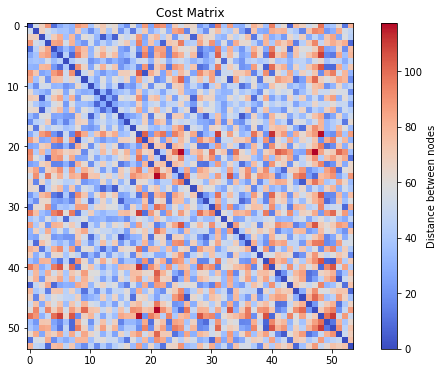

In [61]:
# Cost matrix
coordinates, demands = read_data()
distance_matrix = calculate_distance_matrix(coordinates)

# Plot cost matrix as a heatmap
plt.figure(figsize=(10,6))
plt.imshow(distance_matrix, cmap= 'coolwarm')
plt.colorbar(label='Distance between nodes')
plt.title('Cost Matrix')
plt.show()

Find the solution using the defined algorithm

In [62]:
start_time = time.time()

solution = vrp_solver(capacity)

end_time = time.time()

total_distance = 0
a = 1
for route in solution:
    cost = calculate_total_distance(route, distance_matrix)
    print("Route", a, ":", route, " Cost:" ,f'{cost:.2f}')
    a+=1
    total_distance = total_distance + cost

print("")
print("Total Cost:" , f'{total_distance:.2f}')

#elapsed time
elapsed_time = end_time - start_time
print("Elapsed Time:", f'{elapsed_time:.5f}', "seconds")

Route 1 : [0, 43, 4, 28, 5, 7, 39, 50, 20, 23, 0]  Cost: 95.19
Route 2 : [0, 52, 30, 16, 6, 32, 13, 11, 38, 26, 35, 0]  Cost: 198.63
Route 3 : [0, 18, 49, 29, 15, 10, 1, 36, 17, 45, 0]  Cost: 200.96
Route 4 : [0, 34, 41, 46, 51, 42, 24, 2, 12, 27, 14, 0]  Cost: 181.29
Route 5 : [0, 25, 47, 37, 8, 19, 31, 33, 0]  Cost: 283.64
Route 6 : [0, 44, 53, 3, 22, 0]  Cost: 190.34
Route 7 : [0, 9, 21, 40, 48, 0]  Cost: 283.59

Total Cost: 1433.64
Elapsed Time: 0.03171 seconds


Visualization of the results

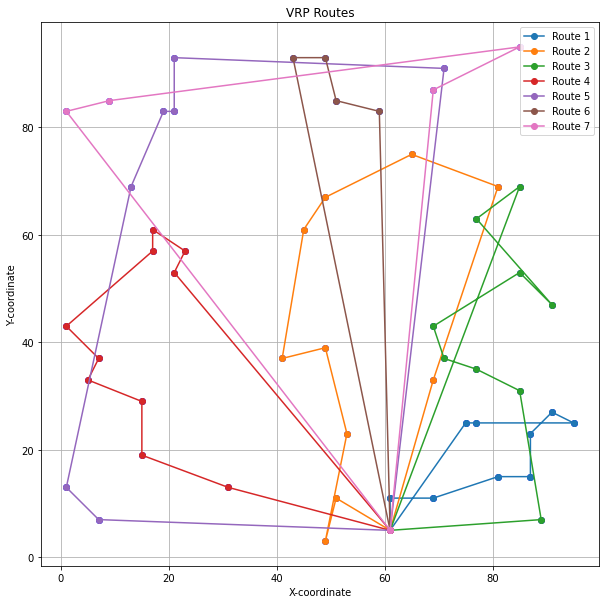

In [63]:
def plot_routes(coordinates, solution):
    """
    Plot the nodes and routes on a 2D plot.
    """
    plt.figure(figsize=(10,10))
    
    # Plot the nodes
    plt.scatter(coordinates[:, 0], coordinates[:, 1], c='blue')

    # Plot the routes
    for i, route in enumerate(solution, 1):
        x_coords = [coordinates[node, 0] for node in route]
        y_coords = [coordinates[node, 1] for node in route]
        x_coords.append(x_coords[0])  # Connect back to the start
        y_coords.append(y_coords[0])  # Connect back to the start
        plt.plot(x_coords, y_coords, marker='o', label=f'Route {i}')
   
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title('VRP Routes')
    plt.legend()
    plt.grid(True)
    plt.show()

    
coordinates, demands = read_data()
plot_routes(coordinates, solution)

### Using 2-opt to improve the Nearest Neighbors results

In [66]:
#Use two opt
def two_opt(routes, dist_matrix, num_iterations):
    best_routes = routes.copy()

    for _ in range(num_iterations):
        selected_route_idx = np.random.randint(0, len(routes))
        selected_route = routes[selected_route_idx]

        i, j = np.random.randint(1, len(selected_route) - 1, size=2)
        if j < i:
            i, j = j, i

        new_route = selected_route.copy()
        new_route[i:j] = selected_route[j - 1: i - 1: -1]  # Reverse the path between i and j

        new_routes = routes.copy()
        new_routes[selected_route_idx] = new_route

        if calculate_total_distance(new_routes[selected_route_idx], dist_matrix) < calculate_total_distance(
                best_routes[selected_route_idx], dist_matrix
        ):
            best_routes = new_routes

    return best_routes

def vrp_solver2(solution, dist_matrix, num_iterations):
    """
    Solve the VRP using the provided filename for coordinates, vehicle capacity,
    and number of iterations for the two-opt optimization.
    """
    optimized_solution = []
    
    for route in solution:
        optimized_route = two_opt([route], dist_matrix, num_iterations)[0]
        optimized_solution.append(optimized_route)

    return optimized_solution

Find the new solution using the defined algorithm

In [67]:
start_time = time.time()

num_iterations = 100000
solution=vrp_solver2(solution, distance_matrix, num_iterations)


end_time = time.time()

total_distance = 0
a = 1
for route in solution:
    cost = calculate_total_distance(route, distance_matrix)
    print("Route", a, ":", route, " Cost:" ,f'{cost:.2f}')
    a+=1
    total_distance = total_distance + cost

print("")
print("Total Cost:" , f'{total_distance:.2f}')


#elapsed time
elapsed_time = end_time - start_time
print("Elapsed Time:", f'{elapsed_time:.5f}', "seconds")

Route 1 : [0, 43, 4, 28, 5, 50, 39, 7, 20, 23, 0]  Cost: 92.20
Route 2 : [0, 30, 52, 16, 6, 32, 13, 11, 38, 26, 35, 0]  Cost: 190.90
Route 3 : [0, 18, 49, 29, 15, 10, 36, 1, 17, 45, 0]  Cost: 196.00
Route 4 : [0, 34, 41, 46, 51, 42, 24, 2, 12, 27, 14, 0]  Cost: 181.29
Route 5 : [0, 25, 47, 37, 8, 19, 31, 33, 0]  Cost: 283.64
Route 6 : [0, 44, 53, 3, 22, 0]  Cost: 190.34
Route 7 : [0, 21, 9, 40, 48, 0]  Cost: 277.72

Total Cost: 1412.09
Elapsed Time: 28.42997 seconds


Visualization of the results

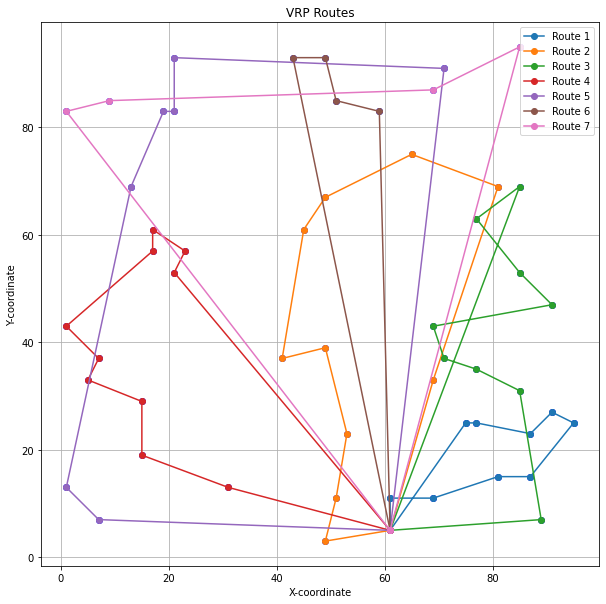

In [68]:
plot_routes(coordinates, solution)